# Title

TODO: write up about project

Notes on installation?
https://github.com/stefan-jansen/machine-learning-for-trading/tree/main/installation

### Import libraries

In [61]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import zipline
from zipline.api import order_percent, order_target, order_value, order, record, symbol
from zipline.finance import commission, slippage
from zipline import run_algorithm

%load_ext zipline
%matplotlib inline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


### Download Tesla stock data from 2011 to 2021

In [37]:
df = yf.download('TSLA', start='2011-01-01', end='2020-12-31')
df = df.reset_index()
df = df.drop(['Adj Close'], axis=1)
df = df.rename(str.lower, axis='columns')
df['dividend'] = 0
df['split'] = 1
df

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close,volume,dividend,split
0,2011-01-03,5.368000,5.400000,5.180000,5.324000,6415000,0,1
1,2011-01-04,5.332000,5.390000,5.204000,5.334000,5937000,0,1
2,2011-01-05,5.296000,5.380000,5.238000,5.366000,7233500,0,1
3,2011-01-06,5.366000,5.600000,5.362000,5.576000,10306000,0,1
4,2011-01-07,5.600000,5.716000,5.580000,5.648000,11239500,0,1
...,...,...,...,...,...,...,...,...
2511,2020-12-23,632.200012,651.500000,622.570007,645.979980,33173000,0,1
2512,2020-12-24,642.989990,666.090027,641.000000,661.770020,22865600,0,1
2513,2020-12-28,674.510010,681.400024,660.799988,663.690002,32278600,0,1
2514,2020-12-29,661.000000,669.900024,655.000000,665.989990,22910800,0,1


### Save data to CSV file

In [38]:
df.to_csv('daily/tsla.csv', header=True, index=False)

### Ingest data
Edit ~/.zipline/extension.py according to zipline docs https://zipline.ml4trading.io/bundles.html#ingesting-data-from-csv-files

In [41]:
!zipline ingest -b tsla-prices-2011-2021

[2021-11-03 02:35:02.409192] INFO: zipline.data.bundles.core: Ingesting tsla-prices-2011-2021.
Loading custom pricing data:   [------------------------------------]    0% | aapl: sid 0
Loading custom pricing data:   [##################------------------]   50% | tsla: sid 1
Loading custom pricing data:   [####################################]  100%
Merging daily equity files:  [####################################]   


In [3]:
!zipline bundles

csvdir <no ingestions>
quandl 2021-10-29 00:52:00.736804
quandl 2021-10-29 00:42:42.964339
quandl 2021-10-28 00:23:28.895431
quantopian-quandl <no ingestions>
tsla-prices-2011-2021 2021-11-03 02:35:02.049493
tsla-prices-2011-2021 2021-11-03 02:34:47.697591
tsla-prices-2011-2021 2021-11-03 02:33:41.454994


## Backtesting Trading Strategies

In [13]:
# variables
ticker = 'TSLA'
start_date = pd.Timestamp("2011-1-1").tz_localize("UTC")
end_date =pd.Timestamp("2019-12-31").tz_localize("UTC")
principal = 10000
bundle_name = "tsla-prices-2011-2021"

In [81]:
# plotting function
def plot(title, results, columns_to_plot):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

    # portfolio value
    results.portfolio_value.plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in $')

    # asset
    results[columns_to_plot].plot(ax=ax[1])
    ax[1].set_ylabel('price in $')

    # mark transactions
    perf_trans = results.loc[[t != [] for t in results.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax[1].plot(buys.index, results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
    ax[1].plot(sells.index, results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
    ax[1].legend()

    # daily returns
    results.returns.plot(ax=ax[2])
    ax[2].set_ylabel('daily returns')

    fig.suptitle(title, fontsize=16)
    plt.legend()
    plt.show()

    print('Final portfolio value (including cash): ${}'.format(np.round(results.portfolio_value[-1], 2)))


### Buy and hold

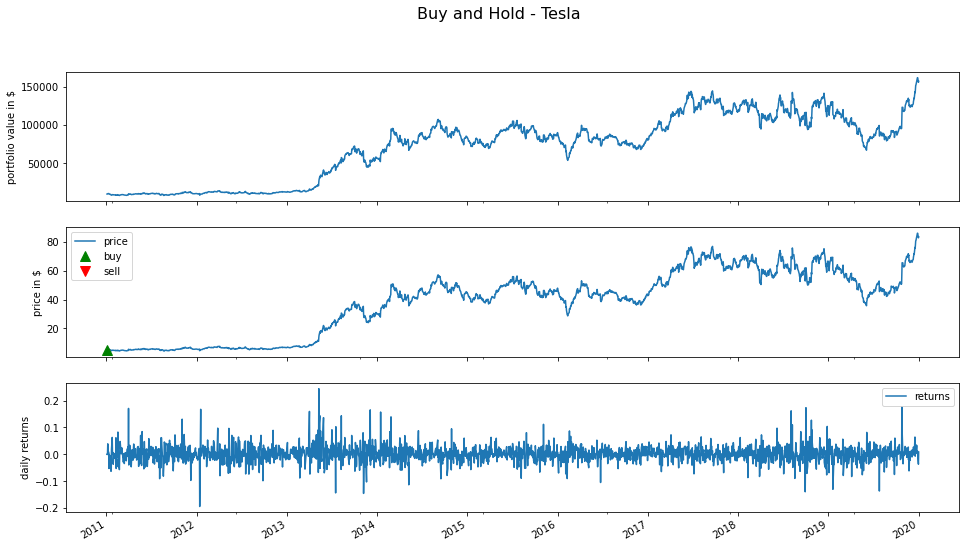

Final portfolio value (including cash): $157100.61


In [82]:
def initialize(context):
    context.asset = symbol(ticker)
    context.has_ordered = False  

def handle_data(context, data):
    record(price=data.current(context.asset, 'price'))
    
    # trading logic
    if not context.has_ordered:
        order_value(context.asset, principal)
        context.has_ordered = True
        
buy_and_hold_results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=principal,
    bundle=bundle_name,
    data_frequency="daily",
)

plot('Buy and Hold - Tesla', buy_and_hold_results, ['price'])

In [ ]:
TODO: capture gain in a data frame? to compare with other strategies

### Dollar cost averaging


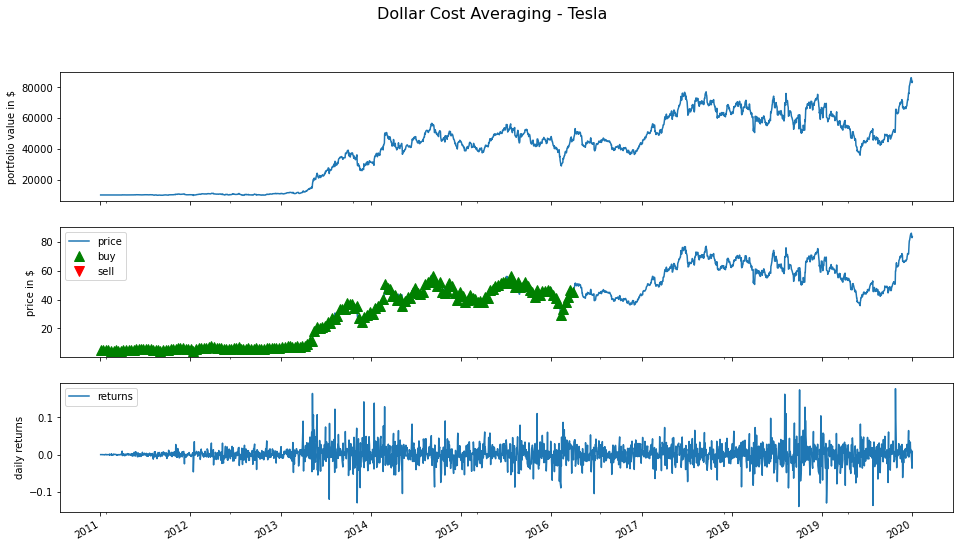

Final portfolio value (including cash): $83767.58


In [83]:
amount_to_invest_weekly = principal / (3*52)

def initialize(context):
    context.days = 0
    context.asset = symbol(ticker)
    context.amount_to_invest_weekly = amount_to_invest_weekly
    context.amont_invested = 0

def handle_data(context, data):
    context.days += 1

    if context.days == 7:
        context.days = 0
        return
    if context.days == 1:
        n_stocks_to_buy = math.floor(context.amount_to_invest_weekly / data.current(context.asset, 'price'))
        if n_stocks_to_buy == 0:
            context.amount_to_invest_weekly += amount_to_invest_weekly
        else:
            context.amont_invested += n_stocks_to_buy * data.current(context.asset, 'price')
            if context.amont_invested < principal:
                order(context.asset, n_stocks_to_buy)
                context.amount_to_invest_weekly = amount_to_invest_weekly
                
    record(price=data.current(context.asset, "price"))
            

dca_results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=principal,
    bundle=bundle_name,
    data_frequency="daily",
)

plot('Dollar Cost Averaging - Tesla', dca_results, ['price'])


### Simple moving average

/Users/josephahn/opt/anaconda3/envs/ml4t/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/josephahn/opt/anaconda3/envs/ml4t/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


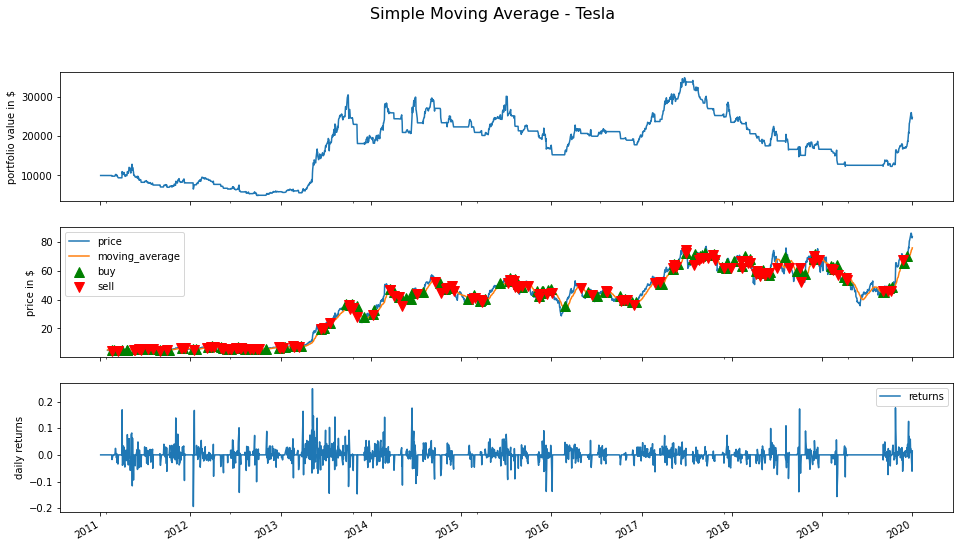

Final portfolio value (including cash): $24730.75


In [84]:
look_back_days = 20

def initialize(context):
    context.days = 0
    context.asset = symbol(ticker)

def handle_data(context, data):
    context.days += 1
    if context.days < look_back_days:
        return

    price_history = data.history(context.asset, fields="price", bar_count=look_back_days, frequency="1d")
 
    # calculate moving averages
    ma = price_history.mean()
    
    # trading logic
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma):
        order_percent(context.asset, 1.0)
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma):
        order_target(context.asset, 0)

    record(price=data.current(context.asset, 'price'),
           moving_average=ma)
    
    
sma_results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=principal,
    bundle=bundle_name,
    data_frequency="daily",
)

plot('Simple Moving Average - Tesla', sma_results, ['price', 'moving_average'])

### Moving Average Crossover

/Users/josephahn/opt/anaconda3/envs/ml4t/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/josephahn/opt/anaconda3/envs/ml4t/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


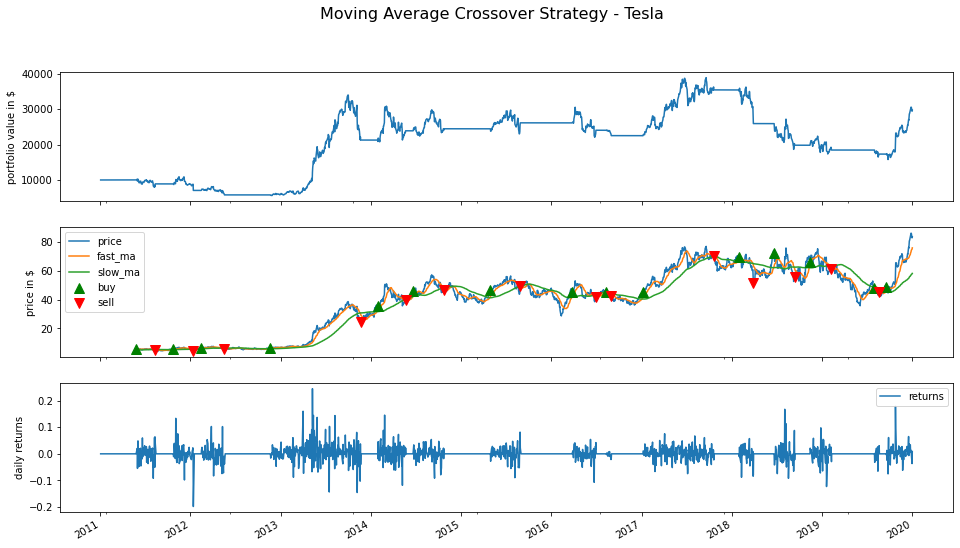

Final portfolio value (including cash): $29652.51


In [85]:
SLOW_MA_PERIODS = 100
FAST_MA_PERIODS = 20

def initialize(context):
    context.days = 0
    context.asset = symbol(ticker)
    context.has_position = False
    
def handle_data(context, data):
    context.days += 1
    if context.days < SLOW_MA_PERIODS:
        return

    # calculate moving averages
    fast_ma = data.history(context.asset, 'price', bar_count=FAST_MA_PERIODS, frequency="1d").mean()
    slow_ma = data.history(context.asset, 'price', bar_count=SLOW_MA_PERIODS, frequency="1d").mean()

    # trading logic
    if (fast_ma > slow_ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    elif (fast_ma < slow_ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           fast_ma=fast_ma,
           slow_ma=slow_ma)

    
mac_results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=principal,
    bundle=bundle_name,
    data_frequency="daily",
)

plot('Moving Average Crossover Strategy - Tesla', mac_results, ['price', 'fast_ma', 'slow_ma'])